In [ ]:
!pip install botorch
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 16.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.9 MB/s eta 0:00:00


In [ ]:
import os
import math
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
%matplotlib inline

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Build black-box function class

In [ ]:
class QTS_OPTIMIZER(nn.Module):
    def __init__(self, ticker_pair, start_date, end_date, riskfree_rate=0.04):
        super(QTS_OPTIMIZER, self).__init__()
        self.ticker_pair = ticker_pair
        self.start_date = start_date
        self.end_date = end_date
        self.riskfree_rate = riskfree_rate
        self.stock = self.get_stock_data()
    
    def get_stock_data(self):
        print("===== DOWNLOADING STOCK DATA =====")
        df = yf.download(self.ticker_pair, start=self.start_date, end=self.end_date)['Adj Close']
        print("===== DOWNLOAD COMPLETE =====")
        return pd.DataFrame(df)
    
    def forward(self, entry_threshold, exit_threshold, window_size=10):
        # add sma columns
        stock_df = self.stock.copy()
        # calculate the spread for GOOG and MSFT
        Y = stock_df[self.ticker_pair[0]]
        X = stock_df[self.ticker_pair[1]]
        # estimate linear regression coefficients
        X_with_constant = sm.add_constant(X)
        model = OLS(Y, X_with_constant).fit()
        # obtain the spread as the residuals
        spread = Y - model.predict() 
        # calculate rolling mean and sd
        spread_mean = spread.rolling(window=window_size).mean()
        spread_std = spread.rolling(window=window_size).std()
        zscore = (spread - spread_mean) / spread_std
        # remove initial days with NA
        first_valid_idx = zscore.first_valid_index()
        zscore = zscore[first_valid_idx:]
        # initialize the daily positions to be zeros
        stock1_position = pd.Series(data=0, index=zscore.index)
        stock2_position = pd.Series(data=0, index=zscore.index)
        # generate daily entry and exit signals for each stock
        for i in range(1, len(zscore)):
            # zscore<-entry_threshold and no existing long position for stock 1
            if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
                stock1_position[i] = 1 # long stock 1
                stock2_position[i] = -1 # short stock 2
            # zscore>entry_threshold and no existing short position for stock 2
            elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
                stock1_position[i] = -1 # short stock 1
                stock2_position[i] = 1 # long stock 2
            # -exit_threshold<zscore<exit_threshold
            elif abs(zscore[i]) < exit_threshold:
                stock1_position[i] = 0 # exit existing position
                stock2_position[i] = 0
            # -entry_threshold<zscore<-exit_threshold or exit_threshold<zscore<entry_threshold
            else:
                stock1_position[i] = stock1_position[i-1] # maintain existing position
                stock2_position[i] = stock2_position[i-1]
        # Calculate the returns of each stock
        stock1_returns = (Y[first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
        stock2_returns = (X[first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
        # calculate the total returns of the strategy
        total_returns = stock1_returns + stock2_returns
        # calculate annualized return 
        annualized_return = (1 + total_returns).prod()**(252/Y[first_valid_idx:].shape[0])-1
        # calculate annualized volatility
        annualized_vol = total_returns.std()*(252**0.5)
        if annualized_vol==0:
            annualized_vol = 100
        # calculate Sharpe ratio 
        sharpe_ratio = (annualized_return - self.riskfree_rate) / annualized_vol
        
        return sharpe_ratio

In [ ]:
qts = QTS_OPTIMIZER(ticker_pair=["GOOG","MSFT"], start_date="2022-01-01", end_date="2023-01-01")

===== DOWNLOADING STOCK DATA =====
[*********************100%***********************]  2 of 2 completed
===== DOWNLOAD COMPLETE =====


In [ ]:
qts.stock.head()

,GOOG,MSFT
Date,,
2022-01-03,145.074493,330.813873
2022-01-04,144.416504,325.141388
2022-01-05,137.653503,312.659851
2022-01-06,137.550995,310.189270
2022-01-07,137.004501,310.347412


In [ ]:
qts(entry_threshold=2, exit_threshold=1)

1.690533096171306

In [ ]:
qts(entry_threshold=1.5, exit_threshold=0.5)

1.8278364562046485

# Generate training data

In [ ]:
# generate initial training dataset for optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
x1_bound = [1,3]
x2_bound = [0,1]

def generate_initial_data(n=10):
    # generate random initial locations
    train_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x2 = torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x = torch.cat((train_x1, train_x2), 1)
    # obtain the exact value of the objective function and add output dimension
    train_y = []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i], exit_threshold=train_x2[i]))
    train_y = torch.Tensor(train_y, device=device).to(dtype).unsqueeze(-1)  
    # get the current best observed value, i.e., utility of the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

train_x, train_y, best_observed_value = generate_initial_data(n=3)
print(train_x)
print(train_y)
print(best_observed_value)

tensor([[1.1221, 0.1771],
        [1.4491, 0.5561],
        [1.4685, 0.1094]], dtype=torch.float64)
tensor([[0.0550],
        [2.2504],
        [1.0004]], dtype=torch.float64)
2.250356674194336


# Initialize and optimize GP model

In [ ]:
# initialize GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    # mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # noise = torch.randn_like(train_y) * 0.01
    # noisy_train_y = train_y + noise
    # model.likelihood.train_targets = noisy_train_y
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    return mll, model

mll, model = initialize_model(train_x, train_y)
list(model.named_hyperparameters())

/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([2.0000], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[0., 0.]], dtype=torch.float64, requires_grad=True))]

In [ ]:
# optimize GP hyperparameters
from botorch.fit import fit_gpytorch_mll
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
fit_gpytorch_mll(mll.cpu())
mll = mll.to(train_x)
model = model.to(train_x)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([0.2238], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(1.1789, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(1.8917, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[-0.8823, -0.9687]], dtype=torch.float64, requires_grad=True))]

# Initialize acquisition function

In [ ]:
# define acquisition function
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient

# call helper functions to generate initial training data and initialize model
train_x, train_y, best_observed_value = generate_initial_data(n=3)
train_x_ei = train_x
train_x_qei = train_x
train_x_ucb = train_x
train_x_qkg = train_x
train_y_ei = train_y
train_y_qei = train_y
train_y_ucb = train_y
train_y_qkg = train_y

mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
beta = 0.8
UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
num_fantasies = 64
qKG = qKnowledgeGradient(
    model=model_qkg,
    num_fantasies=num_fantasies,
    X_baseline=train_x,
    q=1
)

/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [ ]:
# optimize and get new observation
from botorch.optim import optimize_acqf

# get search bounds
bounds = torch.tensor([[x1_bound[0], x2_bound[0]], [x1_bound[1], x2_bound[1]]], device=device, dtype=dtype)
# parallel candidate locations generated in each iteration
BATCH_SIZE = 1
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 1024

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )
    # observe new values 
    new_x = candidates.detach()
    # sample output value
    new_y = qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item()) 
    # add output dimension
    new_y = torch.Tensor([new_y], device=device).to(dtype).unsqueeze(-1)  
    # print("new fn value:", new_y)
    
    return new_x, new_y


In [ ]:
optimize_acqf_and_get_observation(qKG)

(tensor([[1.5470, 0.6003]], dtype=torch.float64),
 tensor([[2.2481]], dtype=torch.float64))

In [ ]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a new random points, 
        observing their values, and updating the current best candidate to the running list.
    """
    new_x1 = x1_bound[0] + (x1_bound[1] - x1_bound[0]) * torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x2 = torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x = torch.cat((new_x1, new_x2), 1)

    new_y = qts(entry_threshold=new_x[0,0].item(), exit_threshold=new_x[0,1].item())
    best_random.append(max(best_random[-1], new_y))       
    return best_random

# Perform sequential search

## two parameters

In [ ]:
# single trial
import time
N_ROUND = 20
verbose = True
beta = 0.8

best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
best_random.append(best_observed_value)
best_observed_ei.append(best_observed_value)
best_observed_qei.append(best_observed_value)
best_observed_ucb.append(best_observed_value)
best_observed_qkg.append(best_observed_value)

# run N_ROUND rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ROUND + 1):    
    t0 = time.monotonic()
    # fit the models
    fit_gpytorch_mll(mll_ei)
    fit_gpytorch_mll(mll_qei)
    fit_gpytorch_mll(mll_ucb)
    fit_gpytorch_mll(mll_qkg)

    # for best_f, we use the best observed exact values
    EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
    qEI = qExpectedImprovement(model=model_qei, 
                               best_f=train_y_ei.max(),
                               num_samples=1024
                               )
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(
        model=model_qkg,
        num_fantasies=64,
        objective=None,
        X_baseline=train_x_qkg,
    )
    
    # optimize and get new observation
    new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
    new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
    new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
    new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
            
    # update training points
    train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
    train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
    train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
    train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
    train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
    train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
    train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
    train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

    # update progress
    best_random = update_random_observations(best_random)
    best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
    best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
    best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
    best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

    best_observed_ei.append(best_value_ei)
    best_observed_qei.append(best_value_qei)
    best_observed_ucb.append(best_value_ucb)
    best_observed_qkg.append(best_value_qkg)

    # reinitialize the models so they are ready for fitting on next iteration
    mll_ei, model_ei = initialize_model(
        train_x_ei, 
        train_y_ei
    )
    mll_qei, model_qei = initialize_model(
        train_x_qei, 
        train_y_qei
    )
    mll_ucb, model_ucb = initialize_model(
        train_x_ucb, 
        train_y_ucb
    )
    mll_qkg, model_qkg = initialize_model(
        train_x_qkg, 
        train_y_qkg
    )

    t1 = time.monotonic()

/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: Inp

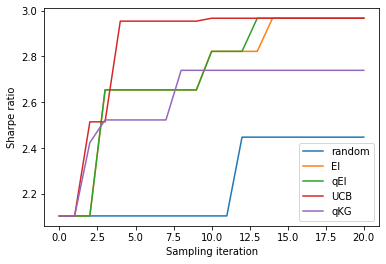

In [ ]:
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
plt.plot(iters, best_random, label='random')
plt.plot(iters, best_observed_ei, label='EI')
plt.plot(iters, best_observed_qei, label='qEI')
plt.plot(iters, best_observed_ucb, label='UCB')
plt.plot(iters, best_observed_qkg, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("Sharpe ratio")
plt.show()

In [ ]:
# multiple trials
# number of runs to assess std of different BO loops
N_TRIALS = 4
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_ROUND = 20
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x, train_y, best_observed_value = generate_initial_data(n=3)
    train_x_ei = train_x
    train_x_qei = train_x
    train_x_ucb = train_x
    train_x_qkg = train_x
    train_y_ei = train_y
    train_y_qei = train_y
    train_y_ucb = train_y
    train_y_qkg = train_y

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    best_random.append(best_observed_value)
    best_observed_ei.append(best_observed_value)
    best_observed_qei.append(best_observed_value)
    best_observed_ucb.append(best_observed_value)
    best_observed_qkg.append(best_observed_value)

    # run N_ROUND rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ROUND + 1):    
        t0 = time.monotonic()
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)

        # for best_f, we use the best observed exact values
        EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei, 
                                  best_f=train_y_ei.max(),
                                  num_samples=1024
                                  )
        UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
        qKG = qKnowledgeGradient(
            model=model_qkg,
            num_fantasies=64,
            objective=None,
            X_baseline=train_x_qkg,
        )
        
        # optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
                
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(
            train_x_ei, 
            train_y_ei
        )
        mll_qei, model_qei = initialize_model(
            train_x_qei, 
            train_y_qei
        )
        mll_ucb, model_ucb = initialize_model(
            train_x_ucb, 
            train_y_ucb
        )
        mll_qkg, model_qkg = initialize_model(
            train_x_qkg, 
            train_y_qkg
        )

        t1 = time.monotonic()
   
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)

/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:173: Inp

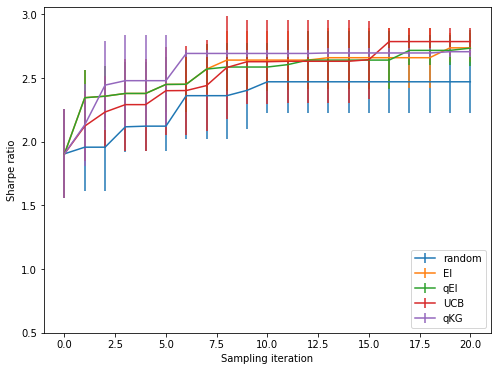

In [ ]:
# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    # return y.std(axis=0)

iters = np.arange(N_ROUND + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_ei_all)
y_qei = np.asarray(best_observed_qei_all)
y_ucb = np.asarray(best_observed_ucb_all)
y_qkg = np.asarray(best_observed_qkg_all)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="EI", linewidth=1.5)
ax.errorbar(iters, y_qei.mean(axis=0), yerr=ci(y_qei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_ucb.mean(axis=0), yerr=ci(y_ucb), label="UCB", linewidth=1.5)
ax.errorbar(iters, y_qkg.mean(axis=0), yerr=ci(y_qkg), label="qKG", linewidth=1.5)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
plt.xlabel("Sampling iteration")
plt.ylabel("Sharpe ratio")
ax.legend(loc="lower right")


In [ ]:
def extract_last_entry(x):
    tmp = []
    for i in range(4):
        tmp.append(x[i][-1])
    return tmp

In [ ]:
rst_df = pd.DataFrame({
    "EI": [np.mean(extract_last_entry(best_observed_ei_all)), np.std(extract_last_entry(best_observed_ei_all))],
    "qEI": [np.mean(extract_last_entry(best_observed_qei_all)), np.std(extract_last_entry(best_observed_qei_all))],
    "UCB": [np.mean(extract_last_entry(best_observed_ucb_all)), np.std(extract_last_entry(best_observed_ucb_all))],
    "qKG": [np.mean(extract_last_entry(best_observed_qkg_all)), np.std(extract_last_entry(best_observed_qkg_all))],
    "random": [np.mean(extract_last_entry(best_random_all)), np.std(extract_last_entry(best_random_all))],
}, index=["mean", "std"])
rst_df

,EI,qEI,UCB,qKG,random
mean,2.736916,2.734416,2.786065,2.706545,2.470426
std,0.116130,0.146371,0.106940,0.041464,0.247212
